In [2]:
import datetime
import sys
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, Model
from sklearn.preprocessing import MinMaxScaler

import src.preprocessing_3days
from src.preprocessing_3days import series_to_supervised, preprocess
from src.functions import load_data, TimeSeriesTensor, create_evaluation_df, plot_train_history, validation, save_model, load_model

np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_seq_items = 2000

import matplotlib.pyplot as plt

In [3]:
def train_test_split(df, n_test):
    if len(df) < 8760:
        n_test = round(len(df) * 0.2)
    test_df = df.copy()[-(n_test+71):]
    train_df = df.copy()[:-(len(test_df)-71)]
    return train_df, test_df

In [4]:
def MIMO_fulldata_preparation(df, n_test=4380, T=72, HORIZON=72):
    df = df.merge(series_to_supervised(df), how='right', left_index=True, right_index=True)
    df = preprocess(df, 'Belgium')
    train_df, test_df = train_test_split(df, n_test)
    y_scaler = MinMaxScaler()
    y_scaler.fit(train_df[['value']])
    long_scaler = MinMaxScaler()
    test_df[test_df.columns] = long_scaler.fit_transform(test_df)
    train_df[train_df.columns] = long_scaler.fit_transform(train_df)
    print(train_df.columns)
    #tensor_structure = {'X':(range(-T+1, 1), train_df.columns[:1]), 'X2':(range(1, 73), train_df.columns[1:6]), 'static':(None, train_df.columns[6:])}
    tensor_structure = {'X':(range(-T+1, 1), train_df.columns[:1]), 'X2':(range(1, 73), train_df.columns[1:])}
    #tensor_structure = {'X':(range(-T+1, 1), train_df.columns)}
    #print(tensor_structure[0])
    train_inputs = TimeSeriesTensor(train_df, 'value', HORIZON, tensor_structure)
    test_inputs = TimeSeriesTensor(test_df, 'value', HORIZON, tensor_structure)
    return train_inputs, test_inputs, y_scaler

In [5]:
GEP1 = pd.read_csv('../data/GEP/Consumption_1H.csv', index_col=0, header=0, names=['value'])
GEP4 = pd.read_csv('../data/GEP/B4_Consumption_1H.csv', index_col=0, header=0, names=['value'])
datasets = [GEP1, GEP4]
names = ['GEP1', 'GEP4']

In [6]:
df = GEP4.merge(series_to_supervised(GEP4), how='right', left_index=True, right_index=True)
df = preprocess(df, 'Belgium')

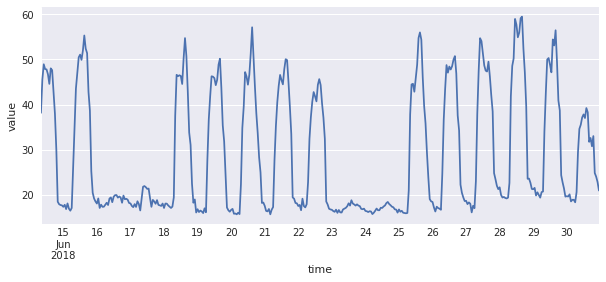

In [23]:
df[800:1200].value.plot()
plt.xlabel('time')
plt.ylabel('value')
plt.style.use('seaborn')#change the style sheets here
plt.rcParams['figure.figsize'] = (10, 4)
plt.savefig(fname='moving_timeline.svg')
plt.show()

In [9]:
df

,value,value(t-168),fractional hour_sin,fractional hour_cos,day of year_sin,day of year_cos,working day,week_1,week_2,week_3,week_4,week_5,week_6,week_7
2018-05-12 00:00:00,22.910,16.378,0.000000,1.000000,0.006178,0.999981,0.0,0,0,0,0,0,1,0
2018-05-12 01:00:00,24.593,16.579,0.010908,0.999941,0.006178,0.999981,0.0,0,0,0,0,0,1,0
2018-05-12 02:00:00,24.769,16.454,0.021815,0.999762,0.006178,0.999981,0.0,0,0,0,0,0,1,0
2018-05-12 03:00:00,26.403,16.804,0.032719,0.999465,0.006178,0.999981,0.0,0,0,0,0,0,1,0
2018-05-12 04:00:00,26.126,16.955,0.043619,0.999048,0.006178,0.999981,0.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29 19:00:00,21.780,21.955,0.205777,0.978599,0.002783,0.999996,0.0,0,0,0,0,0,1,0
2020-02-29 20:00:00,22.181,22.382,0.216440,0.976296,0.002783,0.999996,0.0,0,0,0,0,0,1,0
2020-02-29 21:00:00,22.030,22.130,0.227076,0.973877,0.002783,0.999996,0.0,0,0,0,0,0,1,0
2020-02-29 22:00:00,21.503,22.030,0.237686,0.971342,0.002783,0.999996,0.0,0,0,0,0,0,1,0


In [41]:
df.columns

Index(['value', 'value(t-168)', 'fractional hour_sin', 'fractional hour_cos',
       'day of year_sin', 'day of year_cos', 'working day', 'week_1', 'week_2',
       'week_3', 'week_4', 'week_5', 'week_6', 'week_7'],
      dtype='object')

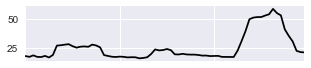

In [79]:
df.iloc[336:(336+72),0].plot(color='black')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.style.use('seaborn')#change the style sheets here
plt.rcParams['figure.figsize'] = (5, 1)
plt.show()

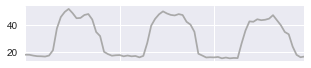

In [83]:
df.iloc[(168-72):168,0].plot(color='darkgrey')
plt.style.use('seaborn')#change the style sheets here
plt.rcParams['figure.figsize'] = (5, 1)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

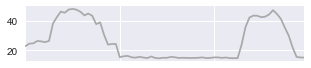

In [84]:
df.iloc[:72,0].plot(color='darkgrey')
plt.style.use('seaborn')#change the style sheets here
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.rcParams['figure.figsize'] = (5, 1)
plt.show()

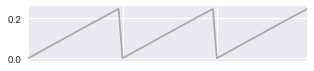

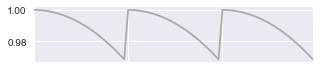

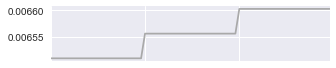

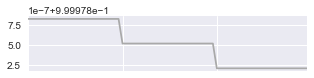

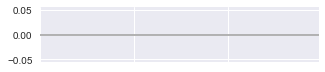

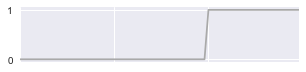

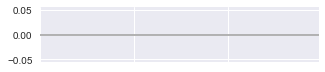

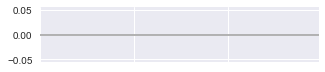

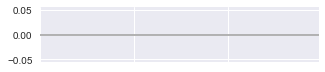

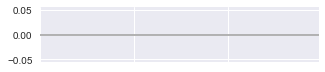

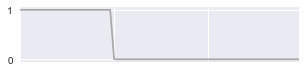

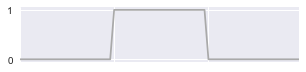

In [81]:
for i in range(2,len(df.columns)):
    df.iloc[168:(168+72),i].plot(color='darkgrey')
    plt.style.use('seaborn')#change the style sheets here
    plt.rcParams['figure.figsize'] = (5, 1)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    plt.show()

In [35]:
len(df.columns)

14